In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")



# Display versions to confirm installations (optional but useful)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

print(f"Seaborn version: {sns.__version__}")



NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2


In [2]:

data = pd.read_csv("C:/Users/avani/Downloads/traffic_info.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [3]:
# Import necessary libraries
import pandas as pd

# Load the data
data = pd.read_csv("C:/Users/avani/Downloads/traffic_info.csv")

def clean_data(data):
    # Display initial data
    print(data.head())
    print(data.columns)

    # Trim any leading or trailing spaces in column names
    data.columns = data.columns.str.strip()

    # Check for invalid dates
    print("Checking for invalid dates...")
    invalid_dates = data[~pd.to_datetime(data['Date'], errors='coerce').notnull()]
    if not invalid_dates.empty:
        print("Invalid dates found:")
        print(invalid_dates)
    else:
        print("No invalid dates found.")

    # Check for invalid times
    print("Checking for invalid times...")
    invalid_times = data[~pd.to_datetime(data['Time'], format='%I:%M:%S %p', errors='coerce').notnull()]
    if not invalid_times.empty:
        print("Invalid times found:")
        print(invalid_times)
    else:
        print("No invalid times found.")

    # Remove invalid rows
    data = data[pd.to_datetime(data['Date'], errors='coerce').notnull()]
    data = data[pd.to_datetime(data['Time'], format='%I:%M:%S %p', errors='coerce').notnull()]

    # Combine 'Date' and 'Time' into 'DateTime'
    data['DateTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

    # Drop 'ID' column if it exists
    data = data.drop(columns=['ID'], errors='ignore')

    # Display DataFrame information
    data.info()

    # Convert vehicle count columns to numeric
    vehicle_columns = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
    for col in vehicle_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        else:
            print(f"Error: '{col}' column is missing")

    # Calculate total vehicle count
    if all(col in data.columns for col in vehicle_columns):
        data['Total'] = data[vehicle_columns].sum(axis=1)
    else:
        print("Error: One or more vehicle count columns are missing")

    # Display final DataFrame information
    data.info()
    return data

# Clean the data

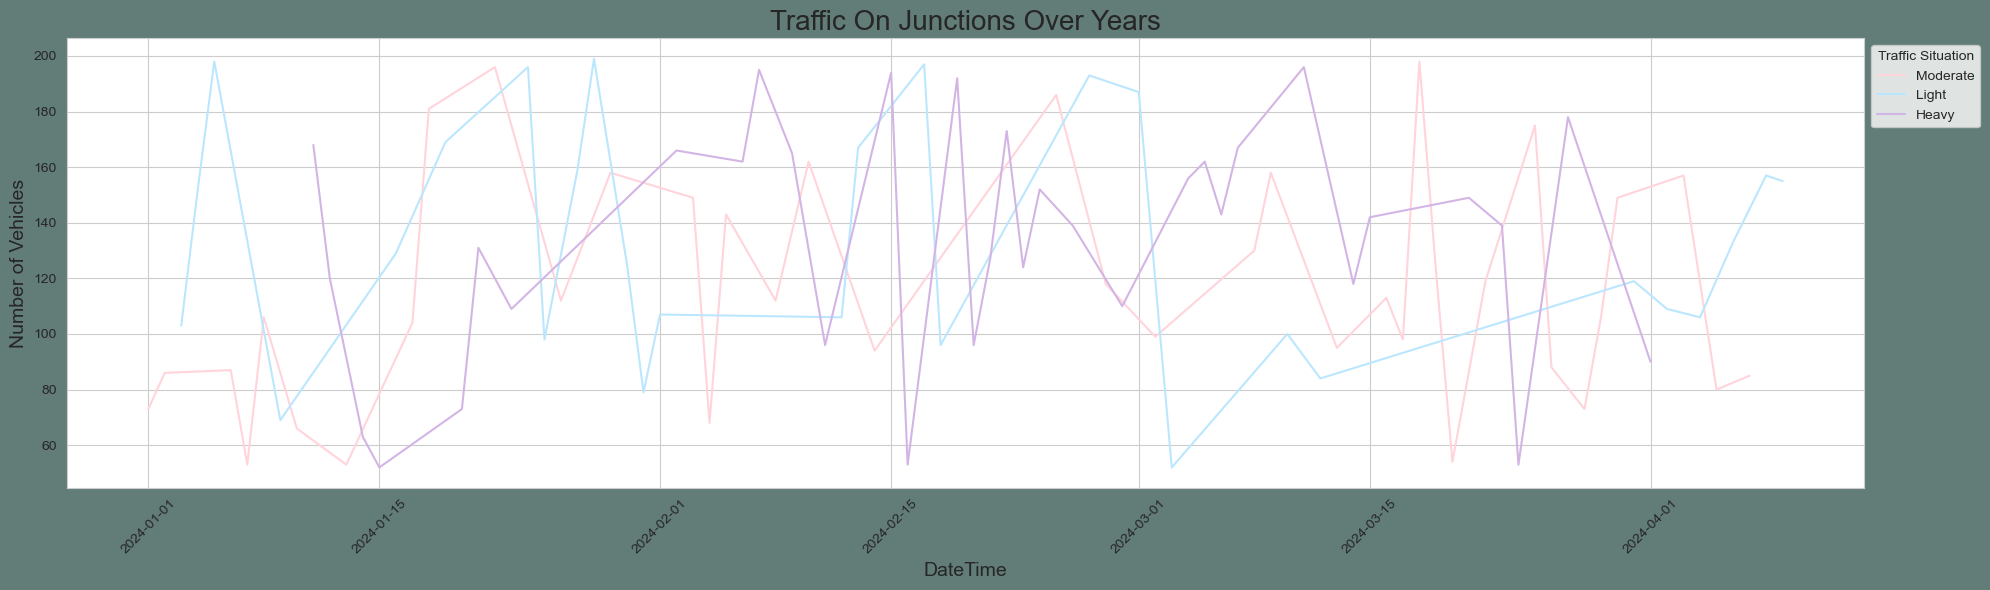

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv("C:/Users/avani/Downloads/traffic_info.csv")
data = pd.DataFrame({
    'DateTime': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'Total': np.random.randint(50, 200, size=100),
    'Traffic Situation': np.random.choice(['Heavy', 'Moderate', 'Light'], size=100)
})


# Define the color palette
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]

# Create the figure and axis
plt.figure(figsize=(20, 6), facecolor="#627D78")

# Check if required columns exist and data is not empty
if not data.empty and all(col in data.columns for col in ['DateTime', 'Total', 'Traffic Situation']):
    # Create the line plot
    Time_series = sns.lineplot(x='DateTime', y='Total', data=data, hue='Traffic Situation', palette=colors)

    # Set the title and labels
    Time_series.set_title("Traffic On Junctions Over Years", fontsize=20)
    Time_series.set_ylabel("Number of Vehicles", fontsize=14)
    Time_series.set_xlabel("DateTime", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True)  # Add grid lines for better visualization

    # Adjust legend position
    plt.legend(title='Traffic Situation', loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()
else:
    print("Data is empty or required columns are missing.")

In [34]:
# Ensure the 'DateTime' column exists
if 'DateTime' not in data.columns:
    raise ValueError("Error: 'DateTime' column is missing in the DataFrame.")

# Define new features and their corresponding extraction methods
new_features = {
    "Year": lambda x: x.dt.year,
    "Month": lambda x: x.dt.month,
    "Date_no": lambda x: x.dt.day,
    "Hour": lambda x: x.dt.hour,
    "Day": lambda x: x.dt.strftime("%A"),
    "Month_Name": lambda x: x.dt.strftime("%B")
}

# Loop through the dictionary to create new columns if they don't already exist
for feature, extraction in new_features.items():
    if feature not in data.columns:
        data[feature] = extraction(data['DateTime'])

# Display the first few rows to verify the new columns have been added
print("New features added to the DataFrame:")
print(data.head())

New features added to the DataFrame:
    DateTime  Total Traffic Situation  Year  Month  Date_no  Hour        Day  \
0 2024-01-01     73          Moderate  2024      1        1     0     Monday   
1 2024-01-02     86          Moderate  2024      1        2     0    Tuesday   
2 2024-01-03    103             Light  2024      1        3     0  Wednesday   
3 2024-01-04    152             Light  2024      1        4     0   Thursday   
4 2024-01-05    198             Light  2024      1        5     0     Friday   

  Month_Name  
0    January  
1    January  
2    January  
3    January  
4    January  


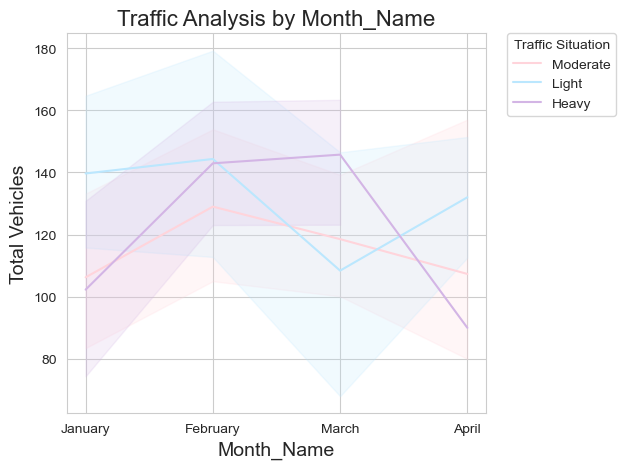

In [ ]:
# Create the line plot
sns.lineplot(x=data[feature], y="Total", data=data, hue="Traffic Situation", palette=colors)

# Set title and labels
plt.title(f"Traffic Analysis by {feature}", fontsize=16)
plt.xlabel(feature, fontsize=14)
plt.ylabel("Total Vehicles", fontsize=14)
plt.legend(title='Traffic Situation', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add grid lines
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

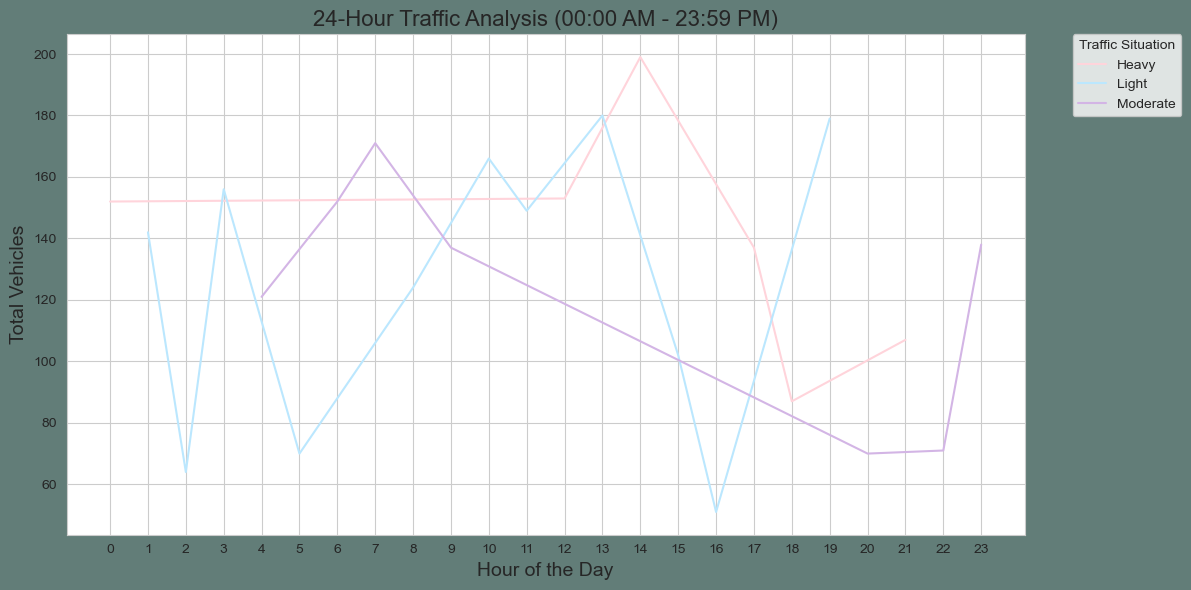

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample Data Generation
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start="2024-01-01 00:00", periods=24, freq='H')  # Generate hourly data for one day
data = pd.read_csv("C:/Users/avani/Downloads/traffic_info.csv")
data = pd.DataFrame({
    'DateTime': dates,
    'Total': np.random.randint(50, 200, size=len(dates)),  # Random total vehicle counts
    'Traffic Situation': np.random.choice(['Heavy', 'Moderate', 'Light'], size=len(dates))  # Random traffic situation
})

# Ensure DateTime is in datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Extracting features from DateTime
data["Year"] = data['DateTime'].dt.year
data["Month"] = data['DateTime'].dt.month
data["Date_no"] = data['DateTime'].dt.day
data["Hour"] = data['DateTime'].dt.hour
data["Day"] = data['DateTime'].dt.strftime("%A")

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define colors for the plots
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5"]

def plot_daily_traffic_analysis(data, colors):
    """Function to plot traffic analysis for a full day (00:00 AM to 23:59 PM)."""
    plt.figure(figsize=(12, 6), facecolor="#627D78")
    
    # Create the line plot
    sns.lineplot(x='Hour', y='Total', data=data, hue='Traffic Situation', palette=colors)
    
    # Set title and labels
    plt.title("24-Hour Traffic Analysis (00:00 AM - 23:59 PM)", fontsize=16)
    plt.xlabel("Hour of the Day", fontsize=14)
    plt.ylabel("Total Vehicles", fontsize=14)
    plt.xticks(range(0, 24))  # Set x-ticks for hours 0-23
    plt.legend(title='Traffic Situation', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Add grid lines
    plt.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot the daily traffic analysis
plot_daily_traffic_analysis(data, colors)


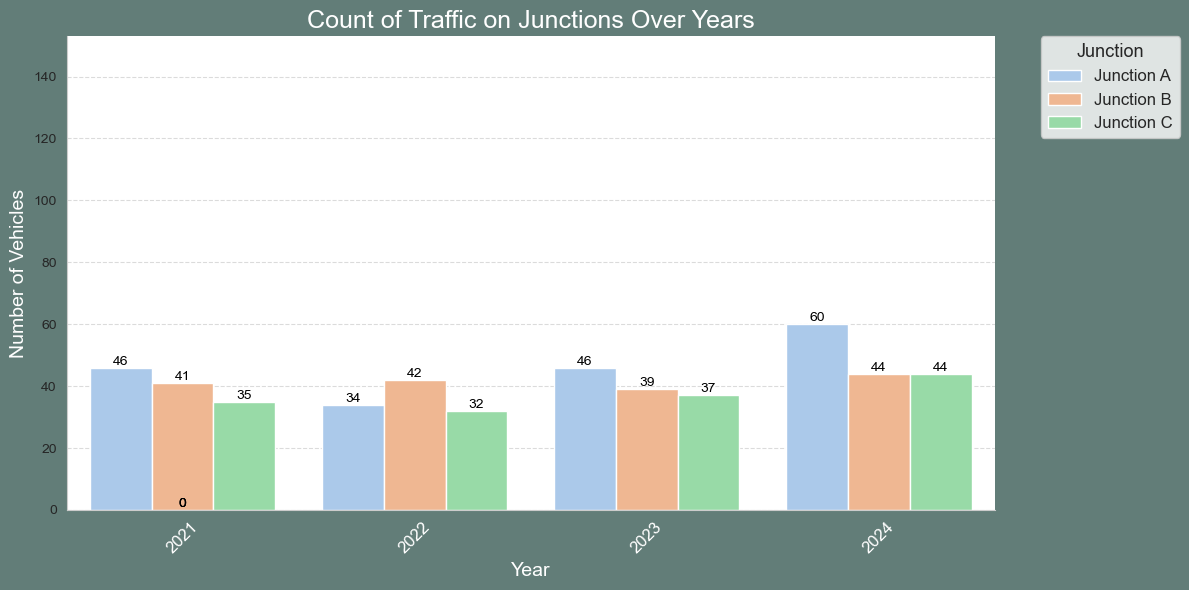

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame for demonstration purposes
import pandas as pd
import numpy as np

# Sample data creation (replace this with your actual data)
np.random.seed(42)
data = pd.read_csv("C:/Users/avani/Downloads/traffic_info.csv")
data = pd.DataFrame({
    'Year': np.random.choice([2021, 2022, 2023, 2024], size=500),
    'Junction': np.random.choice(['Junction A', 'Junction B', 'Junction C'], size=500)
})

# Ensure the 'Junction' column exists
if 'Junction' not in data.columns:
    raise ValueError("Missing required column 'Junction' in the DataFrame.")

# Set the figure size and background color
plt.figure(figsize=(12, 6), facecolor="#627D78")  # Increased height for better visibility

# Create a count plot
colors = sns.color_palette("pastel")  # Use a pastel color palette for better aesthetics
count = sns.countplot(data=data, x="Year", hue="Junction", palette=colors)

# Set the title and labels
count.set_title("Count of Traffic on Junctions Over Years", fontsize=18, color='white')
count.set_ylabel("Number of Vehicles", fontsize=14, color='white')
count.set_xlabel("Year", fontsize=14, color='white')

# Improve x-tick labels for better visibility
count.set_xticklabels(count.get_xticklabels(), rotation=45, fontsize=12, color='white')

# Adjust legend position and style
plt.legend(title='Junction', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12, title_fontsize='13')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits for better visual comparison
plt.ylim(0, data['Year'].value_counts().max() + 5)  # Adjust the limit based on your data

# Add value labels on top of the bars
for p in count.patches:
    count.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', color='black', fontsize=10)

# Improve the overall aesthetics
sns.despine()  # Remove top and right spines for a cleaner look

# Show the plot
plt.tight_layout()  # Adjust layout to fit elements
plt.show()

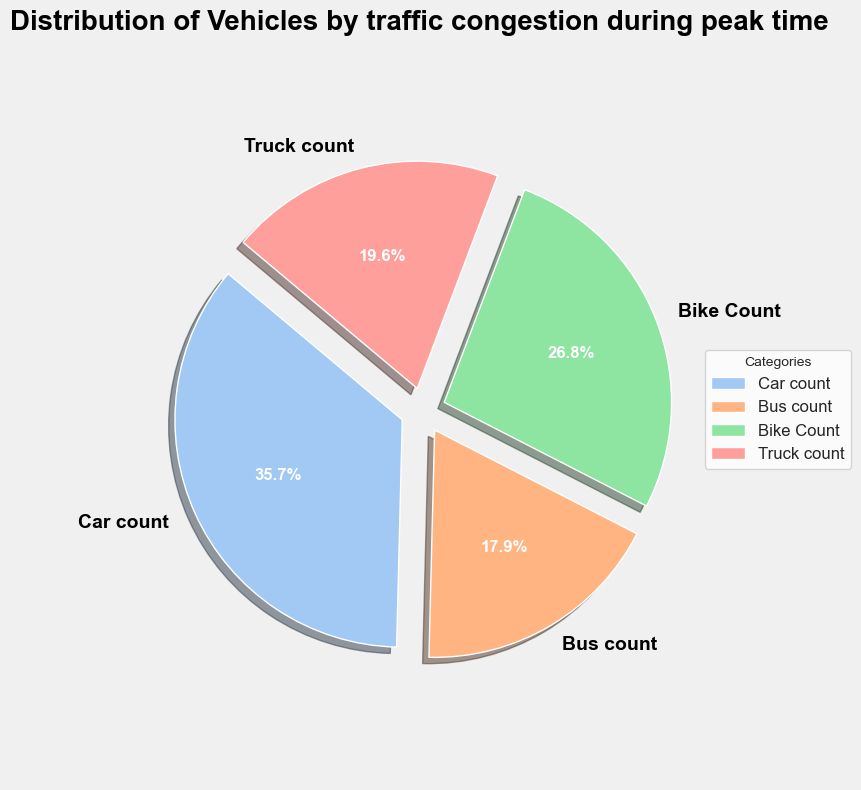

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a pie chart
def create_pie_chart(data, labels, title):
    # Ensure the data is in the correct format
    if len(data) != len(labels):
        raise ValueError("Data and labels must have the same length.")
    
    # Define a color palette
    colors = sns.color_palette("pastel", len(labels))

    # Create the pie chart
    plt.figure(figsize=(8, 8), facecolor="#f0f0f0")
    wedges, texts, autotexts = plt.pie(
        data,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        shadow=True,
        explode=[0.1] * len(labels)  # Slightly explode each slice for emphasis
    )

    # Customize the font properties
    plt.setp(texts, size=14, weight='bold', color='black')  # Set label text properties
    plt.setp(autotexts, size=12, weight='bold', color='white')  # Set percentage text properties

    plt.title(title, fontsize=20, weight='bold', color='black')
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

    # Add a legend
    plt.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

    # Show the plot
    plt.tight_layout()  # Adjust layout to fit elements
    plt.show()

# Example usage
if __name__ == "__main__":
   # Sample data
    data = [200, 100, 150, 110 ]  
    labels = ['Car count ', 'Bus count ', 'Bike Count', 'Truck count']  
    title = "Distribution of Vehicles by traffic congestion during peak time "  

    # Create the pie chart
    create_pie_chart(data, labels, title)

    data = [200, 100, 150, 110]  
    labels = ['Car count', 'Bus count', 'Bike count', 'Truck count']  
    title = "My Custom Pie Chart"